In [1]:
%run style/talktools.py

# FOXSI
# AIA - Brightenings
## Method by Kobelski, McKenzie and Donachie [2014]
### Author: Milo BC
***May, 2018***

**Kobelski, McKenzie and Donachie [2014]**:  <br>
http://iopscience.iop.org/article/10.1088/0004-637X/786/2/82/pdf <br>
The detection algorithm is based on the method of Berghmans & Clette (1999), which looks for enhancements in the observed flux on a pixel by pixel basis. Enhancements in neighboring pixels are then grouped together and defined as an ARTB. <br><br/>

This approach involves subtracting a running mean from the time profile of brightness in each pixel, then looking for residuals larger than a predefined threshold, typically three standard deviations.<br><br/>

After calibration and co-alignment, a running mean of the image stack is created by applying a temporal boxcar smoothing of width $\omega_{rm}$. This temporally smoothed version of the image is then subtracted from the original image, resulting in a residual with the mean removed.
The next step is to determine the standard deviation of the light curves for each pixel in the image stack, which is used to make a ratio between the residual and the standard deviation. The “brightest” pixel in this ratio is determined to be an ARTB as long as it is greater than $q_D$, the detection threshold. All pixels in the ratio array that are larger than a second threshold, $q_C$ , are then checked for connectivity to the $q_D$ point.<br><br/>
A good $\omega_{rm}$ to start is $\approx 10$ min.

In [2]:
from sunpy.time import TimeRange
import glob
from sunpy.map import Map
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

**FOXSI Parameters:**

In [3]:
Ftarget = {'cen1_pos0':(359.0, -431.0), # arcsec
           'cen1_pos1':(-1.0, -431.0),
           'cen1_pos2':(-1.0, -251.0),
           'cen2_pos0':(-1.0, -281.0),
           'cen2_pos1':(-390.0, -281.0),
           'cen3_pos0':(1210.5, -431.5),
           'cen3_pos1':(850.0, -431.5),
           'cen3_pos2':(850.0, -251.0),
           'cen4':(200.0, 750.0),
           'cen5':(0.0, -251.0),
           'cen_Iris':(11,-260)}
Ftimes = {'cen1_pos0': TimeRange(['2014-12-11 19:12:42', '2014-12-11 19:13:14.3']),
            'cen1_pos1':TimeRange(['2014-12-11 19:13:18','2014-12-11 19:13:42.6']),
            'cen1_pos2':TimeRange(['2014-12-11 19:13:46.5','2014-12-11 19:14:25']),
            'cen2_pos0':TimeRange(['2014-12-11 19:14:29','2014-12-11 19:14:39.6']),
            'cen2_pos1':TimeRange(['2014-12-11 19:14:44','2014-12-11 19:15:36.7']),
            'cen3_pos0':TimeRange(['2014-12-11 19:15:40.6','2014-12-11 19:16:07.2']),
            'cen3_pos1':TimeRange(['2014-12-11 19:16:11','2014-12-11 19:16:30.1']),
            'cen3_pos2':TimeRange(['2014-12-11 19:16:34','2014-12-11 19:17:09.2']),
            'cen4':TimeRange(['2014-12-11 19:17:13.5','2014-12-11 19:18:46.2']),
            'cen5':TimeRange(['2014-12-11 19:18:50.5','2014-12-11 19:19:23.2']),
            't_shtr':TimeRange(['2014-12-11 19:18:18','2014-12-11 19:18:22']),
            'Iris_Obs':TimeRange(['2014-12-11 19:12:22','2014-12-11 19:39:01'])}
fov = (1000,1000) # arcsec

Reading AIA data:

In [4]:
data_dir = '/Volumes/Storage/FOXSI/AIA/'
str_indices = {'94':'', '131':'', '171':'', '193':'', '211':'', '304':'', '335':'', '1600':'', '1700':''}
file_list = {}
maps = {}
for key in str_indices:
    file_list.update({key: glob.glob(data_dir + '*' + key + '*.fits')})

### Reading, co-ratating and cropping all AIA data:

In [5]:
irisfov = [180,180] #arcsec
these_files = file_list['94'] # All maps
maps = []
for f in these_files:
    smap = Map(f)
    top_right =   SkyCoord((Ftarget['cen_Iris'][0] + irisfov[0]/2) * u.arcsec, 
                           (Ftarget['cen_Iris'][1] + irisfov[1]/2) * u.arcsec, frame=smap.coordinate_frame)
    bottom_left = SkyCoord((Ftarget['cen_Iris'][0] - irisfov[0]/2) * u.arcsec, 
                           (Ftarget['cen_Iris'][1] - irisfov[1]/2) * u.arcsec,frame=smap.coordinate_frame)
    submap = smap.submap(bottom_left, top_right)
    maps.append(submap)

/Users/Kamilobu/anaconda3/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


Defining `mean`, `std`, and `get_neighbours` *functions*:

In [6]:
def mean(cmaps):
    """
    Calculate the average of the data array.
    """
    _meta = []
    for i, m in enumerate(cmaps):
        _meta.append(m.meta)
    data = np.zeros((cmaps[0].data.shape[0], cmaps[0].data.shape[1], len(cmaps)), dtype=cmaps[0].data.dtype)
    for i, m in enumerate(cmaps):
        data[:, :, i] = m.data
    return Map(np.mean(data, axis=2), _meta[1])

def std(cmaps):
    """
    Calculate the standard deviation of the data array.
    """
    _meta = []
    for i, m in enumerate(cmaps):
        _meta.append(m.meta)
    data = np.zeros((cmaps[0].data.shape[0], cmaps[0].data.shape[1], len(cmaps)), dtype=cmaps[0].data.dtype)
    for i, m in enumerate(cmaps):
        data[:, :, i] = m.data
    return Map(np.std(data, axis=2), _meta[1])

def get_neighbours2(data, cell):
    """Find the neighbouring values for the cell in the 'data' list
           data : A homogenous 2d list (i.e. all rows are the same length)
       cell : A 2-tuple with row, column in order
    """
    neighbours = []
    row, col = cell[0], cell[1]
    row_max = len(data) # Get upper bound of row length
    col_max = len(data[0])
 
    return [data[row_d + row][col_d + col]
    for col_d in [-1,0,1]
        if (0 <= (col_d + col) < col_max) or (col_d == 0 and row_d==0)
    for row_d in [-1,0,1]
    if 0 <= (row_d + row) < row_max ]

Making `maps`, `bright_maps`, `maps_qd`, and `maps_qc` for IRIS observation:

In [144]:
wrm = 44 # (int) time width - 44 frames is equivalent to 10 min
qd = 4
qc = 3
smap,bright_maps,maps_qd,maps_qc = [],[],[],[]

for i in range(53,86):
    maps_i = maps[i-wrm//2:i+wrm//2]   # Takes wrm 'frames' around frame i
    mean_i = mean(maps_i) # Calculates the mean around i
    residual_i = (maps[i].data - mean_i.data) # residual data
    std_i = std(maps[i-wrm//2:i+wrm//2]).data # STD 
    data_qd = (residual_i/std_i)
    data_qd[np.where((residual_i/std_i)<=qd)] = 0.0 # Data under QD TH
    data_qc = (residual_i/std_i)
    data_qc[np.where((residual_i/std_i)<=qc)] = 0.0 # Data under QC TH
    smap.append(maps[i])
    maps_qd.append(Map(data_qd, mean_i.meta))
    maps_qc.append(Map(data_qc, mean_i.meta))
    bright_maps.append(Map(residual_i/std_i, mean_i.meta))

/Users/Kamilobu/anaconda3/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


### Plotting one of the maps with the qd and qc parameters as an example

/Users/Kamilobu/anaconda3/lib/python3.6/site-packages/sunpy/map/mapbase.py:1735: Warning: This map is not properly oriented. Plot axes may be incorrect
  Warning)


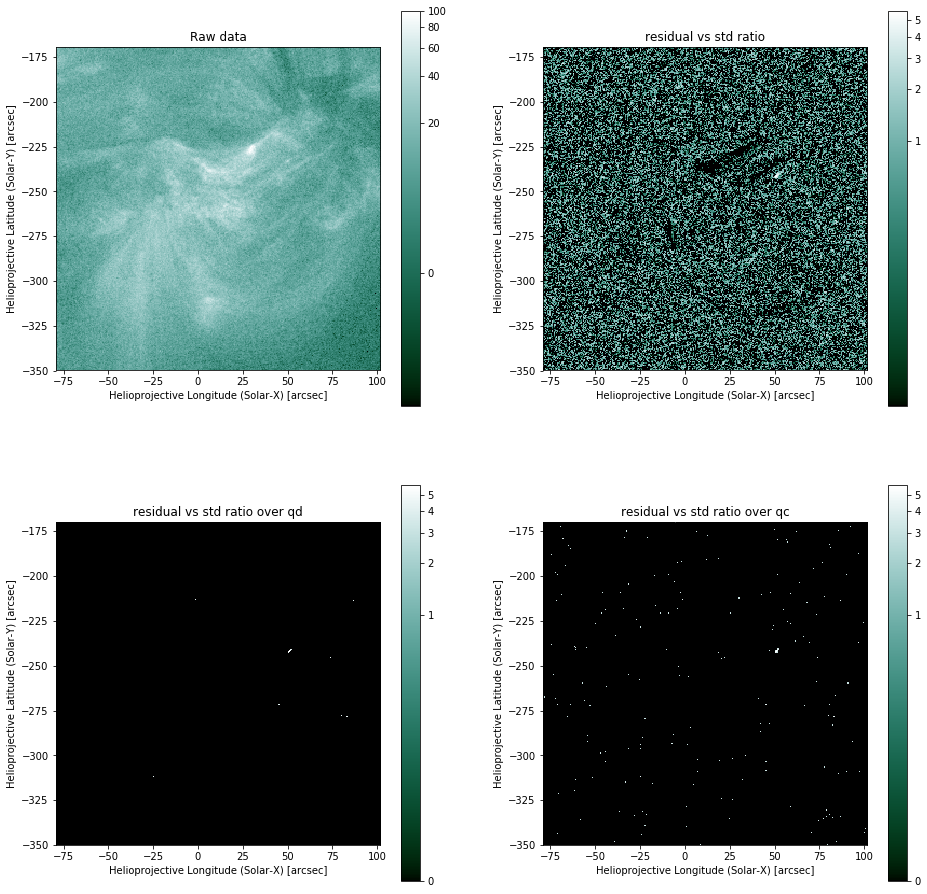

In [157]:
i = 32 
%matplotlib inline
'''Plotting'''
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
maps[i].plot(title='Raw data')
plt.colorbar()
plt.subplot(2,2,2)
bright_maps[i].plot(vmin=0.01, title='residual vs std ratio')
plt.colorbar()
plt.subplot(2,2,3)
maps_qd[i].plot(title='residual vs std ratio over qd')
plt.colorbar()
plt.subplot(2,2,4)
maps_qc[i].plot(title='residual vs std ratio over qc')
plt.colorbar()
plt.show()

### 3D Neighbours Function:

In [148]:
def get_neighbours_3d(data, cell):
    """
    """
    neighbours = []
    tim, row, col = cell[0], cell[1], cell[2]
    tim_max = len(data) 
    row_max = len(data[0]) # Get upper bound of row length
    col_max = len(data[0][0])
    
    return [data[tim_d + tim][row_d + row][col_d + col]
    for tim_d in [-1,0,1]
           if (0 <= (tim_d + tim) < tim_max) or (tim_d == 0 and col_d == 0 and row_d == 0)
    for row_d in [-1,0,1]
           if 0 <= (row_d + row) < row_max
    for col_d in [-1,0,1]
           if 0 <= (col_d + col) < col_max ]

### Making 3D data maps

In [149]:
data_maps, data_bright_maps, data_maps_qd, data_maps_qc = [], [], [], []

# maps: 
for m in maps: data_maps.append(m.data)
data_maps = np.array(data_maps)

# bright_maps: 
for m in bright_maps: data_bright_maps.append(m.data)
data_bright_maps = np.array(data_bright_maps)

# maps_qd: 
for m in maps_qd: data_maps_qd.append(m.data)
data_maps_qd = np.array(data_maps_qd)

# maps_qc: 
for m in maps_qc: data_maps_qc.append(m.data)
data_maps_qc = np.array(data_maps_qc)


### Finding clusters of bright pixels:

In [156]:
BPTH = 5 # Minimum number of pixel together defining a brightening
brightpixel = []
for i in np.argwhere(data_maps_qd):
    if np.count_nonzero(get_neighbours_3d(data_maps_qc,i))>=BPTH: 
        print(i,np.count_nonzero(get_neighbours_3d(data_maps_qc,i)))
        brightpixel.append(i)

[  9 218 197] 5
[ 17 195 242] 6
[ 17 195 243] 5
[ 24 176 221] 6
[ 24 177 221] 6
[ 32 179 215] 6
[ 32 179 216] 9
[ 32 180 216] 7
[ 32 180 217] 6
[ 32 181 217] 6
[ 32 181 218] 5


In [158]:
tmax = 32
file_list['94'][53 + tmax][40:62]

'2014_12_11t19_19_13_12'